# CNN Model Testing

In [26]:
import numpy as np
import os
import utils
from CNNModel import CNN
from torch import optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from bayes_opt import BayesianOptimization

**There are three versions of MNIST dataset**

In [8]:
dataTypes = ["digits-normal.mat", "digits-scaled.mat", "digits-jitter.mat"]

# Accuracy placeholder
accuracy = np.zeros(len(dataTypes))
trainSet = 1
testSet = 2

dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/", "data", "digits-jitter.mat")
data = utils.loadmat(dataPath)

### Functions Overview

This notebook includes several key functions used for model training, evaluation, reinitialization, and hyperparameter tuning:

- **train(model, dataloader, loss_function, optimizer, epochs, display=True)**  
  Trains the model on the training dataset over a specified number of epochs. It performs forward and backward passes, updates the model parameters, computes the loss and accuracy for each epoch, and optionally prints these metrics. The function returns arrays with the epoch-wise loss and accuracy.

- **evaluate(model, dataloader, loss_function)**  
  Evaluates the model's performance on the test dataset. It computes the average loss and accuracy by running the model in evaluation mode (with gradient calculations disabled) to ensure consistency during inference.

- **reset_weights(m)**  
  A utility function that reinitializes the weights of a model layer if it supports weight resetting (i.e., has a `reset_parameters` method). This is useful when you need to restart training from scratch or perform hyperparameter tuning.

- **objective(learning_rate, batch_size, num_epochs)**  
  Defines the objective function for Bayesian optimization. It takes hyperparameters as inputs (learning rate, batch size, and number of epochs), casts those that need to be integers, trains the model using these hyperparameters, and evaluates its test accuracy. The test accuracy is returned as the metric to be maximized during the optimization process.


In [33]:
def train(model, dataloader, loss_function, optimizer, epochs, display=True):
    model.train()
    loss_arr = np.zeros(epochs)
    acc_arr = np.zeros(epochs)
    
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0
        
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
        
        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        loss_arr[epoch] = total_epoch_loss
        acc_arr[epoch] = epoch_accuracy
        
        if display:
            print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")
    
    return loss_arr, acc_arr
def evaluate(model, dataloader, loss_function):
    # Evaluate model performance on the test dataset
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0
    # Disable gradient calculations when in inference mode
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    return test_loss, test_acc
def reset_weights(m):
    # Check if the layer has a reset_parameters attribute and call it
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
def objective(learning_rate, batch_size, num_epochs, xTrain, yTrain, xTest, yTest):
    # Convert continuous hyperparameters to integers where necessary
    batch_size = int(batch_size)
    num_epochs = int(num_epochs)
    
    # Define model, loss function, and optimizer
    model = CNN()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create DataLoaders with drop_last=True to avoid batches with a single sample
    train_dataset = TensorDataset(xTrain, yTrain)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    test_dataset = TensorDataset(xTest, yTest)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # Reset weights before training
    model.apply(reset_weights)
    
    # Train the model without display output during hyperparameter tuning
    train(model, train_loader, loss_function, optimizer, num_epochs, display=False)
    
    # Evaluate on the test set
    _, test_acc = evaluate(model, test_loader, loss_function)
    
    # Return test accuracy (to be maximized)
    return test_acc


**Hyperparameter Tuning**

In [ ]:
# Find optimal hyperparameters for a specific dataset
dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/")
dataType = dataTypes[2]
path = os.path.join(dataPath, "data", dataType)
data = utils.loadmat(path)
print("+++ Loading dataset: {} ({} images)".format(dataType, data["x"].shape[2]))

# Preprocess the data
x = data["x"].transpose([2, 0, 1])
x = np.reshape(x, [x.shape[0], 1, x.shape[1], x.shape[2]])
y = data["y"]

x = torch.tensor(x).float()
y = torch.tensor(y).long()

xTrain = x[data["set"] == trainSet, :, :, :]
yTrain = y[data["set"] == trainSet]
xTest = x[data["set"] == testSet, :, :, :]
yTest = y[data["set"] == testSet]

# Define the bounds for each hyperparameter
pbounds = {
    'learning_rate': (1e-5, 1e-2),
    'batch_size': (32, 128),
    'num_epochs': (50, 100)
}

# Set up Bayesian Optimization.
# Extra keyword arguments (xTrain, yTrain, etc.) will be passed to the objective function.
optimizer_bo = BayesianOptimization(
    f=lambda learning_rate, batch_size, num_epochs: objective(learning_rate, batch_size, num_epochs, xTrain, yTrain, xTest, yTest),
    pbounds=pbounds,
    random_state=42,
)

# Run the optimization process
optimizer_bo.maximize(
    init_points=5,  # random explorations
    n_iter=10       # iterations for Bayesian optimization
)

print("Best parameters found:")
print(optimizer_bo.max)


+++ Loading dataset: digits-jitter.mat (2000 images)
|   iter    |  target   | batch_... | learni... | num_ep... |
-------------------------------------------------------------


+++ Loading dataset: digits-normal.mat (2000 images)


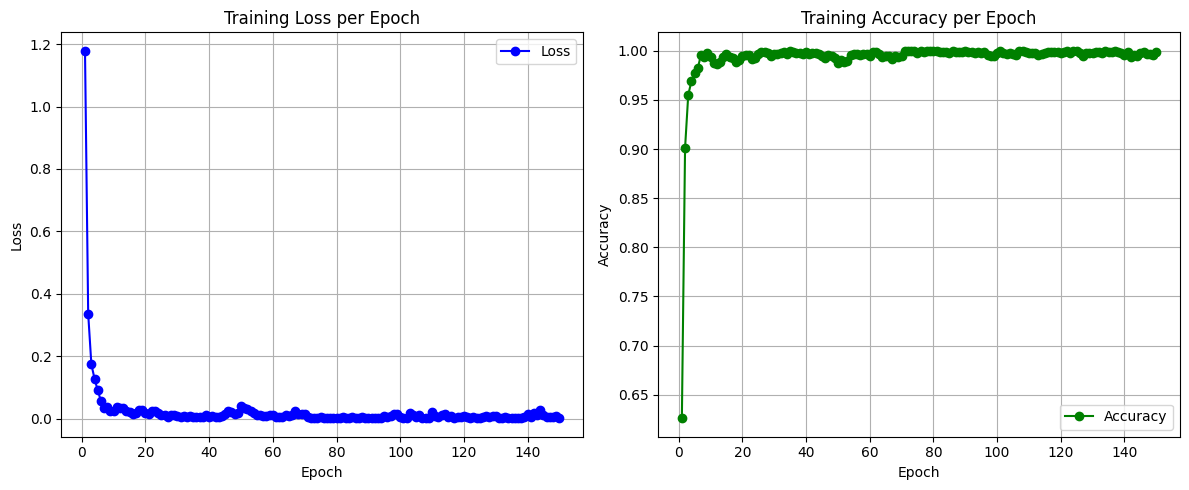

Test accuracy: 0.95
+++ Loading dataset: digits-scaled.mat (2000 images)


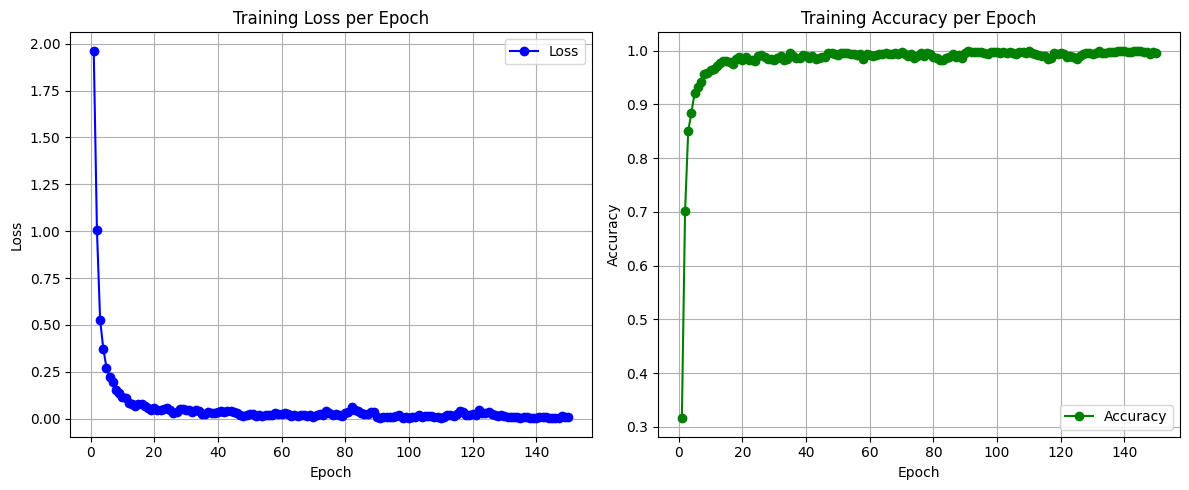

Test accuracy: 0.932
+++ Loading dataset: digits-jitter.mat (2000 images)


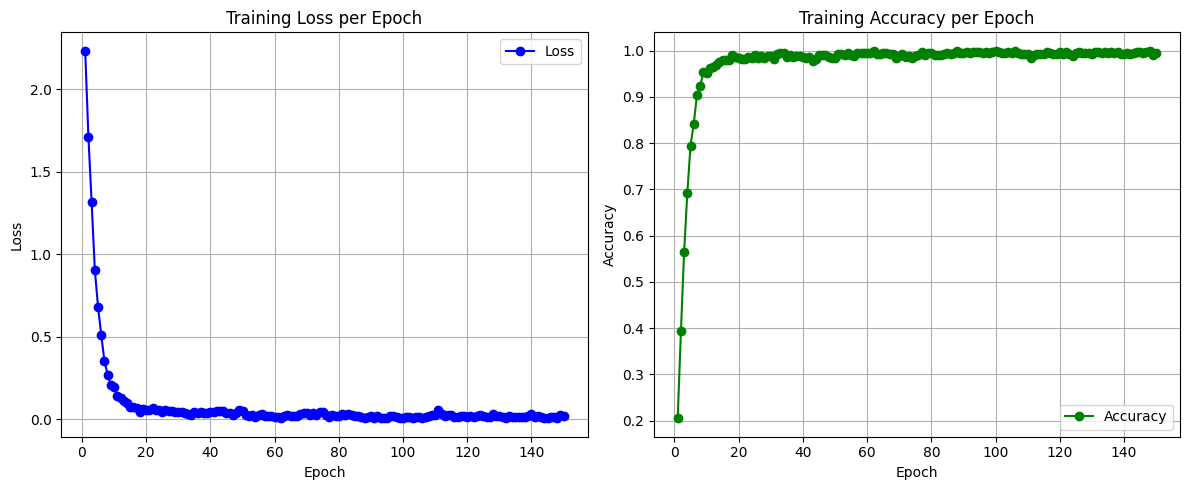

Test accuracy: 0.808


In [22]:
dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/")
accuracy = np.zeros(len(dataTypes))
for dataset_idx in range(len(dataTypes)):
    dataType = dataTypes[dataset_idx]

    # Load data
    path = os.path.join(dataPath, "data", dataType)
    data = utils.loadmat(path)
    print("+++ Loading dataset: {} ({} images)".format(dataType, data["x"].shape[2]))

    x = data["x"].transpose([2, 0, 1])
    x = np.reshape(x, [x.shape[0], 1, x.shape[1], x.shape[2]])
    y = data["y"]

    x = torch.tensor(x).float()
    y = torch.tensor(y).long() 

    xTrain = x[data["set"] == trainSet, :, :, :]
    yTrain = y[data["set"] == trainSet]

    xTest = x[data["set"] == testSet, :, :, :]
    yTest = y[data["set"] == testSet]

    # Hyperparameters
    hyperparams = {
        "batch_size": 64,
        "learning_rate": 0.001,
        "num_epochs": 150
    }

    # Define model, loss function and optimizer
    model = CNN()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])


    # Create train dataset and loader
    train_dataset = TensorDataset(xTrain, yTrain)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=True
    )

    # Create test dataset and loader
    test_dataset = TensorDataset(xTest, yTest)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=True
    )
    model.apply(reset_weights)

    EPOCHS = hyperparams["num_epochs"]
    loss, acc = train(model, train_loader, loss_function, optimizer, EPOCHS, display=False)

    # Create subplots for training loss and accuracy
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), loss, marker='o', linestyle='-', color='blue', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), acc, marker='o', linestyle='-', color='green', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, loss_function)
    accuracy[dataset_idx] = test_acc
    print('Test accuracy:', test_acc)

In [24]:
# Print the results in a table
print("+++ Accuracy Table [trainSet={}, testSet={}]".format(trainSet, testSet))
print("--------------------------------------------------")
print("dataset\t\t\t", end="")
print("{}\t".format("cnn"), end="")
print()
print("--------------------------------------------------")
for dataset_idx in range(len(dataTypes)):
    print("{}\t".format(dataTypes[dataset_idx]), end="")
    print("{:.2f}\t".format(accuracy[dataset_idx] * 100))

+++ Accuracy Table [trainSet=1, testSet=2]
--------------------------------------------------
dataset			cnn	
--------------------------------------------------
digits-normal.mat	95.00	
digits-scaled.mat	93.20	
digits-jitter.mat	80.80	
